In [256]:
import pandas  as pd
import numpy as np
import random 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from itertools import chain
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
train_data =pd.read_csv("./dataset/train.csv", nrows = 100000)
destinations_data =pd.read_csv("./dataset/destinations.csv", nrows = 100000)

In [258]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


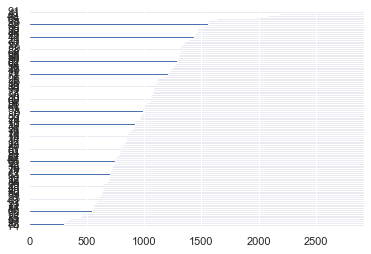

In [206]:
train_data.hotel_cluster.value_counts().sort_values().plot(kind = 'barh')

### The hotel cluster 91 has more no of visits

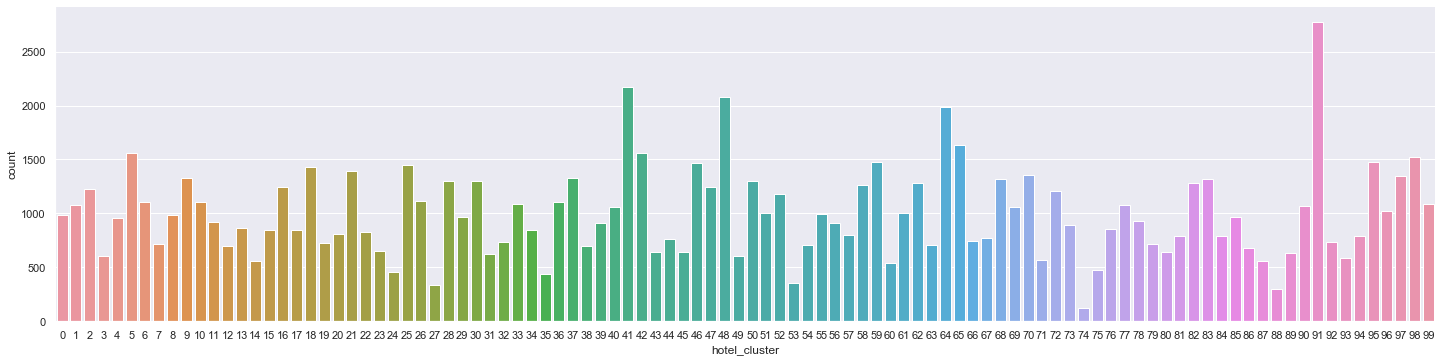

In [230]:
sns.set_theme(style="darkgrid")
sns.catplot(x="hotel_cluster", data=train_data, kind='count', aspect = 4)

### To get more insights, we are adding year and month extracted from date_time attribute

In [259]:
train_data["date_time"] = pd.to_datetime(train_data["date_time"])
train_data["month"] = train_data["date_time"].dt.month
train_data["year"] = train_data["date_time"].dt.year

In [260]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,8,2014
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,8,2014
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,8250,1,0,1,2,50,628,1,8,2014
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,14984,1,0,1,2,50,1457,80,8,2014
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,14984,1,0,1,2,50,1457,21,8,2014


#### The training data has no linear correlation with any attributes in the dataset.

In [261]:
train_data.corr()["hotel_cluster"]

site_name                   -0.019154
posa_continent               0.002204
user_location_country       -0.025170
user_location_region         0.008037
user_location_city          -0.006580
orig_destination_distance    0.011362
user_id                      0.001396
is_mobile                   -0.002803
is_package                   0.051955
channel                     -0.005956
srch_adults_cnt              0.007322
srch_children_cnt            0.005469
srch_rm_cnt                 -0.005801
srch_destination_id         -0.007258
srch_destination_type_id    -0.030064
is_booking                  -0.025380
cnt                          0.000914
hotel_continent             -0.008441
hotel_country               -0.021170
hotel_market                 0.036107
hotel_cluster                1.000000
month                        0.001208
year                         0.000696
Name: hotel_cluster, dtype: float64

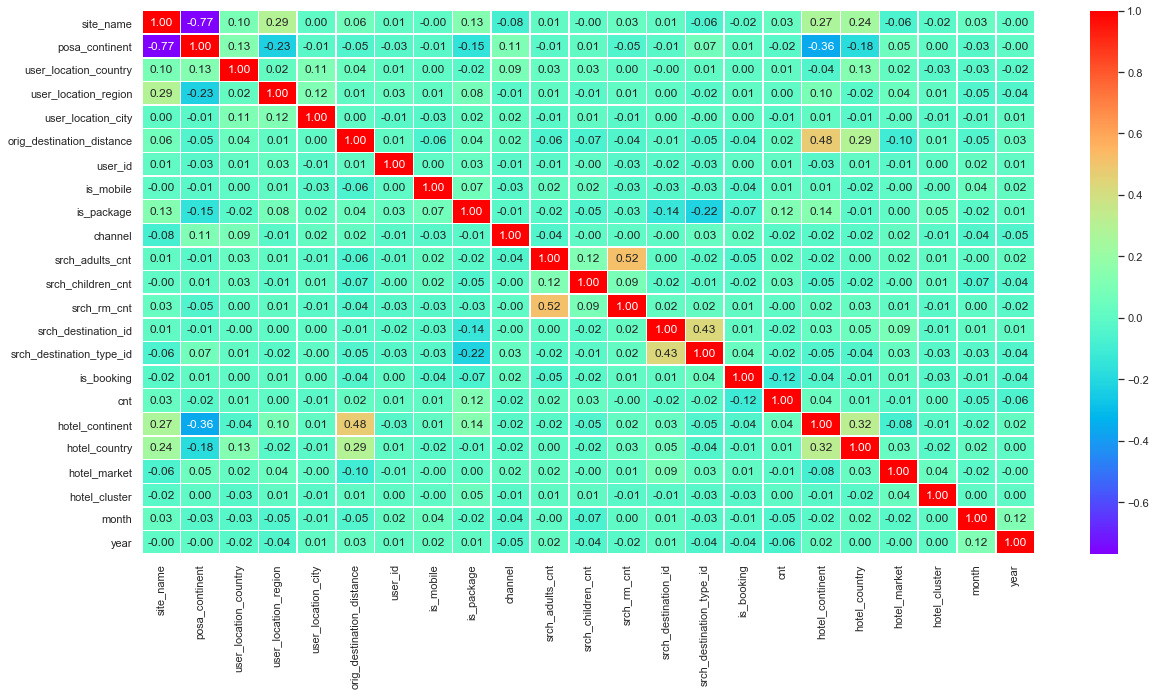

In [211]:
corr = train_data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(round(corr, 2).iloc[:, :], annot=True, linewidths=.5, ax=ax, cmap="rainbow",fmt='.2f')

In [262]:
users_uni = train_data.user_id.unique()  
sampled_userids = []
for k in sorted(random.sample(range(len(users_uni)),100)):
    sampled_userids.append(users_uni[k])
    
sampled_train = train_data[train_data.user_id.isin(sampled_userids)]
sampled_train

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
74,2013-02-15 13:18:43,2,3,66,462,41898,2716.6746,1482,0,0,...,8857,1,0,1,2,50,214,28,2,2013
75,2013-02-16 11:57:50,2,3,66,462,41898,2716.5257,1482,0,0,...,8857,1,0,1,2,50,214,73,2,2013
76,2013-02-16 12:03:45,2,3,66,462,41898,2722.4856,1482,0,0,...,8857,1,0,1,2,50,214,26,2,2013
77,2013-02-16 12:23:57,2,3,66,462,41898,2716.6746,1482,0,0,...,8857,1,0,1,2,50,214,28,2,2013
78,2014-01-03 16:19:15,2,3,66,462,41898,2454.8588,1482,0,1,...,12009,1,0,1,2,50,680,95,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99198,2014-05-14 22:08:23,25,2,23,48,4924,NaN,387883,0,0,...,8744,1,0,1,3,106,108,15,5,2014
99301,2014-01-26 19:08:58,37,1,69,612,53531,NaN,388158,0,1,...,8785,1,0,5,6,105,35,22,1,2014
99302,2014-01-26 19:17:34,37,1,69,612,53531,NaN,388158,0,1,...,8785,1,0,2,6,105,35,64,1,2014
99303,2014-01-26 19:19:21,37,1,69,612,53531,NaN,388158,0,1,...,8785,1,0,1,6,105,35,22,1,2014


#### The data is split in training and testing. As test.csv contains data aged above 2014, the testing_set has been sampled accordingly

In [263]:
training_set = sampled_train[(((sampled_train.month < 8) & (sampled_train.year == 2014)) | (sampled_train.year == 2013))]
testing_set = sampled_train[((sampled_train.month >= 8) & (sampled_train.year == 2014))]

In [264]:
training_set.shape, testing_set.shape

((1203, 26), (1073, 26))

In [265]:
testing_set = testing_set[testing_set.is_booking == True]
testing_set.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
268,2014-12-28 20:38:09,24,2,3,64,9448,NaN,2451,0,0,...,65035,6,1,1,6,105,29,10,12,2014
276,2014-12-29 01:11:43,24,2,3,64,9448,NaN,2451,0,0,...,8746,1,1,1,6,105,29,99,12,2014
306,2014-12-30 04:51:53,24,2,3,64,9448,NaN,2451,0,0,...,14039,6,1,1,6,105,35,78,12,2014
331,2014-12-30 08:56:35,24,2,3,64,9448,NaN,2451,0,0,...,33393,6,1,1,6,105,12,8,12,2014
351,2014-12-30 12:43:43,24,2,3,64,9448,NaN,2451,0,0,...,21787,6,1,1,6,105,29,15,12,2014


#### Initially setting the recommended cluster values based on their value counts

In [266]:
initial_cluster_values = list(train_data.hotel_cluster.value_counts().head().index)
initial_cluster_values

[91, 41, 48, 64, 65]

In [267]:
top_five_clusters = []
clusters_count = testing_set.shape[0]
for cluster in range(clusters_count):
    top_five_clusters.append(initial_cluster_values)

In [268]:
training_set['hotel_cluster']

74       28
75       73
76       26
77       28
78       95
         ..
99198    15
99301    22
99302    64
99303    22
99304    22
Name: hotel_cluster, Length: 1203, dtype: int64

In [269]:
destinations_data.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [270]:
pca = PCA(n_components=3)  
reduced_dest = pca.fit_transform(destinations_data[["d{0}".format(i+1) for i in range(149)]])
reduced_dest = pd.DataFrame(reduced_dest)  
reduced_dest["srch_destination_id"]= destinations_data["srch_destination_id"]

In [271]:
reduced_dest

,0,1,2,srch_destination_id
0,-0.044268,0.169419,0.032522,0
1,-0.440761,0.077405,-0.091572,1
2,0.001033,0.020677,0.012109,2
3,-0.480467,-0.040345,-0.019320,3
4,-0.207253,-0.042694,-0.011744,4
...,...,...,...,...
62101,0.031398,-0.191479,-0.064768,64989
62102,0.071925,-0.174147,0.071126,64990
62103,0.166190,0.208037,0.217181,64991
62104,-0.581395,-0.027664,-0.054205,64992


In [274]:
def features_imp(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    attributes = {}
    for col in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        attributes[col] = getattr(df["date_time"].dt, col)
    
    extra_attr = []
    for col in df.columns:
        if col not in ["srch_ci", "date_time", "srch_co"]:
            extra_attr.append(col)
            
    for attr in extra_attr:
        attributes[attr] = df[attr]
    
    feature_dates = ["month", "day", "dayofweek", "quarter"]
    for attr in feature_dates:
        attributes["ci_{0}".format(attr)] = getattr(df["srch_ci"].dt, attr)
        attributes["co_{0}".format(attr)] = getattr(df["srch_co"].dt, attr)
    attributes["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    updated_df = pd.DataFrame(attributes)
    updated_df = updated_df.join(reduced_dest, on="srch_destination_id", how='left', rsuffix="dest")
    updated_df = updated_df.drop("srch_destination_iddest", axis=1)
    return updated_df

In [275]:
new_df = features_imp(training_set)
new_df.fillna(-1, inplace=True)

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [277]:
new_df

,month,day,hour,minute,dayofweek,quarter,site_name,posa_continent,user_location_country,user_location_region,...,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,stay_span,0,1,2
74,2,15,13,18,4,1,2,3,66,462,...,24.0,1.0,6.0,4.0,1.0,1.0,120.0,0.092590,-0.129584,-0.263312
75,2,16,11,57,5,1,2,3,66,462,...,24.0,1.0,6.0,4.0,1.0,1.0,120.0,0.092590,-0.129584,-0.263312
76,2,16,12,3,5,1,2,3,66,462,...,24.0,1.0,6.0,4.0,1.0,1.0,120.0,0.092590,-0.129584,-0.263312
77,2,16,12,23,5,1,2,3,66,462,...,1.0,6.0,4.0,2.0,1.0,1.0,120.0,0.092590,-0.129584,-0.263312
78,1,3,16,19,4,1,2,3,66,462,...,21.0,26.0,4.0,2.0,1.0,1.0,120.0,0.581930,-0.216003,-0.109185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99198,5,14,22,8,2,2,25,2,23,48,...,22.0,23.0,6.0,0.0,2.0,2.0,24.0,-0.275253,0.294496,-0.015332
99301,1,26,19,8,6,1,37,1,69,612,...,9.0,13.0,6.0,3.0,1.0,1.0,96.0,-0.539366,-0.022431,-0.024282
99302,1,26,19,17,6,1,37,1,69,612,...,9.0,13.0,6.0,3.0,1.0,1.0,96.0,-0.539366,-0.022431,-0.024282
99303,1,26,19,19,6,1,37,1,69,612,...,9.0,13.0,6.0,3.0,1.0,1.0,96.0,-0.539366,-0.022431,-0.024282


In [278]:
probabilities_list = [] 
non_target_cols = []

unique_clusters = new_df["hotel_cluster"].unique()

for _ in unique_clusters:
    new_df["target_class"]=1
    new_df['target_class'][new_df["hotel_cluster"]!=cluster]=0
    for col in new_df:
        if col not in ['hotel_cluster', 'target_class']:
            non_target_cols.append(col)
    
    probs = []  
    cv=KFold(n_splits = 2)  
    
    clf = RandomForestClassifier(n_estimators=10)
    for tr,te in cv.split(training_set):
        clf.fit(new_df[non_target_cols].iloc[tr],new_df["target_class"].iloc[tr])
        preds = clf.predict_proba(new_df[non_target_cols].iloc[te])
        curr = []
        for p in preds:
            if len(p) >= 2:
                curr.append(p[1])
        probs.append(curr)
    full_probs = chain.from_iterable(probs)
    probabilities_list.append(list(full_probs))
    
user_cluster_frame = pd.DataFrame(probabilities_list).T  
user_cluster_frame.columns = unique_clusters 

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

In [279]:
user_cluster_frame

,28,73,26,95,77,13,42,82,37,99,...,45,1,23,96,93,80,84,71,88,34
0,0.2,0.2,0.1,0.2,0.2,0.2,0.2,0.2,0.1,0.1,...,0.4,0.1,0.2,0.4,0.1,0.1,0.2,0.2,0.3,0.2
1,0.2,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.0,0.1,...,0.3,0.1,0.2,0.3,0.1,0.1,0.2,0.2,0.3,0.2
2,0.2,0.2,0.1,0.2,0.2,0.2,0.3,0.3,0.2,0.1,...,0.4,0.1,0.2,0.4,0.1,0.2,0.2,0.3,0.3,0.2
3,0.2,0.0,0.1,0.1,0.2,0.1,0.2,0.3,0.0,0.1,...,0.3,0.1,0.2,0.3,0.1,0.1,0.2,0.2,0.2,0.1
4,0.2,0.0,0.0,0.0,0.0,0.3,0.1,0.1,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
def top_five_clusters(user):
    return list(user.nlargest(5).index)

In [281]:
cluster_preds = []
for _, r in user_cluster_frame.iterrows():
    cluster_preds.append(top_five_clusters(r))

In [282]:
cluster_preds

[[62, 15, 22, 3, 39],
 [62, 15, 22, 3, 20],
 [62, 15, 22, 3, 39],
 [15, 62, 3, 61, 39],
 [13, 28, 90, 42, 82],
 [13, 90, 28, 82, 35],
 [13, 28, 82, 90, 35],
 [13, 90, 28, 82, 57],
 [13, 28, 82, 90, 57],
 [13, 90, 28, 82, 42],
 [13, 28, 82, 90, 57],
 [13, 28, 42, 82, 25],
 [28, 13, 90, 82, 42],
 [13, 28, 82, 90, 22],
 [13, 28, 82, 90, 22],
 [13, 90, 22, 28, 82],
 [13, 28, 82, 90, 57],
 [13, 28, 82, 90, 57],
 [13, 90, 28, 82, 57],
 [13, 90, 28, 82, 57],
 [13, 28, 82, 90, 22],
 [13, 28, 82, 90, 22],
 [13, 90, 28, 22, 96],
 [13, 28, 90, 22, 96],
 [13, 90, 28, 82, 22],
 [43, 22, 6, 63, 60],
 [43, 22, 6, 63, 60],
 [41, 95, 63, 35, 56],
 [35, 41, 63, 95, 56],
 [63, 41, 6, 59, 95],
 [6, 63, 59, 95, 56],
 [18, 62, 45, 73, 31],
 [18, 62, 45, 73, 31],
 [99, 38, 50, 22, 63],
 [63, 24, 95, 25, 56],
 [99, 38, 50, 63, 76],
 [99, 38, 50, 22, 63],
 [63, 24, 95, 56, 19],
 [63, 24, 95, 56, 19],
 [73, 99, 38, 50, 41],
 [45, 73, 99, 38, 50],
 [45, 73, 99, 38, 50],
 [99, 38, 22, 41, 63],
 [63, 41, 19, 24, 3

In [283]:
len(cluster_preds)

1203